In [ ]:
from pymeasure.instruments import list_resources
list_resources()

In [1]:
import datetime
import os
import sys
from utilities import make_folder, int_ask

# Set the project name
user_list = os.listdir('/Users/lznus/Desktop/Data-Keithley/')
for i, user in enumerate(user_list):
    print(f'{i+1:02}: {user}')
user_ID = int(input('Select your user ID'))
user_name = user_list[user_ID-1]
project_name = input('Enter project name: ')
while project_name == '':
    print('Error: Project name cannot be empty')
    project_name = input('Enter project name: ')
    
# Get the date
today = datetime.datetime.today().strftime('%y%m%d')
project_dir = f"/Users/lznus/Desktop/Data-Keithley/{user_name}/{today}_IV-pulse_{project_name}"

# Create the project directory if it does not exist
make_folder(project_dir)
# Create the project directory if it does not exist
fig_dir = f"/Users/lznus/Desktop/Data-Keithley/{user_name}/{today}_IV-pulse_{project_name}/figures"
make_folder(fig_dir)

01: Paul
02: Ren
03: Soumya
04: Yuki


Select your user ID 4
Enter project name:  Au-MPB-C60-BCP-Cu


Folder named "/Users/lznus/Desktop/Data-Keithley/Yuki/230615_IV-pulse_Au-MPB-C60-BCP-Cu" has been prepared.
Folder named "/Users/lznus/Desktop/Data-Keithley/Yuki/230615_IV-pulse_Au-MPB-C60-BCP-Cu/figures" has been prepared.


In [7]:
import numpy as np
# Set the voltage source (V)
start_voltage = -10 #V
end_voltage = 10 # V
step_size = 2 #V/step
source_voltage = np.arange(start_voltage, end_voltage+step_size, step_size) # prepare voltage sources
# Set the delay time (second)
t_ON = 0.020 #s
t_INT = 20 #s
total_time = len(source_voltage) * (t_INT + t_ON)
# Set the filename
file_name = input('Enter file name: ')
filename = os.path.join(project_dir, file_name + '.csv')
if total_time < 60:
    print(f'Estimated total time is {int(total_time)} sec')
elif total_time >= 60 and total_time <= 3600:
    print(f'Estimated total time is {int(total_time)/60} min')
elif total_time > 3600:
    print(f'Estimated total time is {int(total_time)/3600} hrs')

Enter file name:  230528-0.2mmh_-10Vto10V


Estimated total time is 3.6666666666666665 min


Time: 167.10 s
Voltage: 5.988 V
Current: 1.778e-11 A


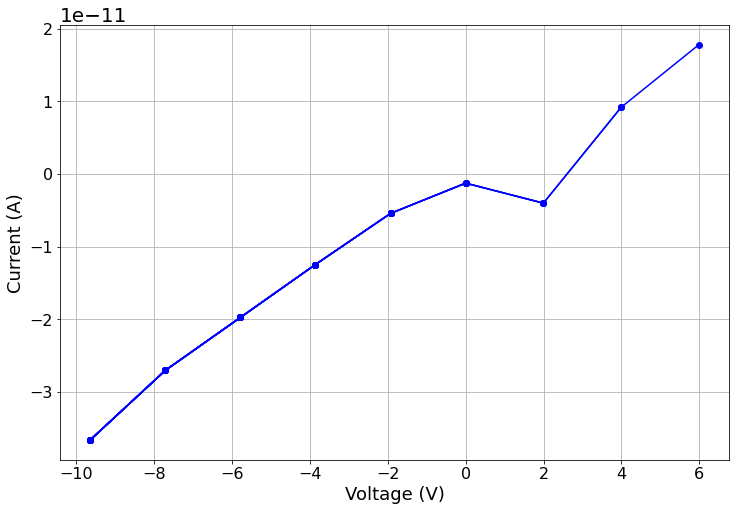

KeyboardInterrupt: 

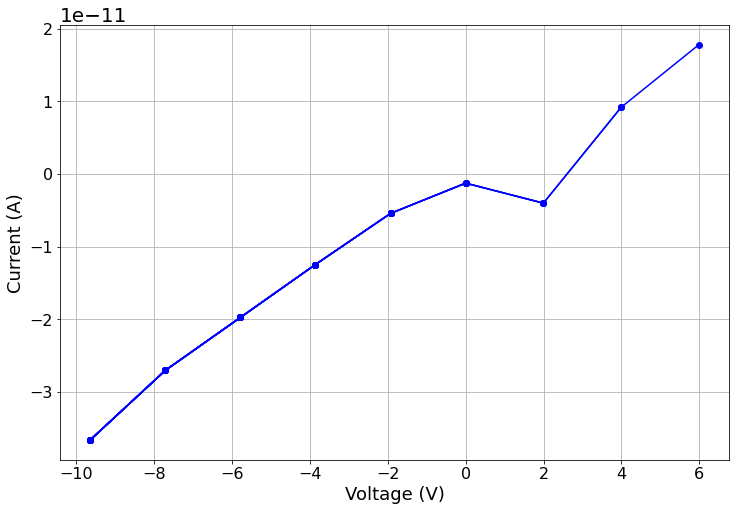

In [8]:
import pyvisa as visa
import time
import csv
import datetime
import sys
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Check Parameters
print(f'File name: {file_name}.csv')

# Make sure if you start or not
START = input('Press Enter to Start')
if START == '':
    print("\n Let's get started :)")
    pass
else:
    sys.exit(0)
    
# Open a connection to the Keithley 2450
try:
    rm = visa.ResourceManager()
    keithley = rm.open_resource('USB0::0x05E6::0x2450::04491080::INSTR')
except:
    print("Error: Could not connect to instrument")
    sys.exit(0)

# Initialize the time and current arrays
times = []
t_ON_list = []
currents = []
voltages = []

# Set up the real-time plot
plt.ion()
fig = plt.figure(figsize=(12,8))
plt.rcParams["font.size"] = 20
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')

# Start the measurement and real-time plot
start_time = time.perf_counter()
for i in range(len(source_voltage)):
    clear_output(wait=True)
    # Set the voltage source
    keithley.write(f'SOURCE:VOLTAGE:LEVEL {source_voltage[i]}')
    # Set the voltage source output on
    keithley.write('OUTPUT ON')
    output_start = time.perf_counter()
    voltage = float(keithley.query('MEASURE:VOLTAGE?'))
    current = float(keithley.query('MEASURE:CURRENT?'))
    if (t_ON - (time.perf_counter() - output_start)) > 0:
        time.sleep(t_ON - (time.perf_counter() - output_start))
    else:
        pass
    
    # Set the voltage source output off
    keithley.write('OUTPUT OFF')
    times.append((time.perf_counter() - start_time))

    output_end = time.perf_counter()
    t_ON_list.append(output_end - output_start)
    
    currents.append(current)
    voltages.append(voltage)
    print(f'Time: {times[-1]:.2f} s')
    print(f'Voltage: {voltage:.4g} V')
    print(f'Current: {current:.4g} A')
    plt.plot(voltages[-100:], currents[-100:], linestyle='-', marker='o', label='Current', color='blue')
    plt.xlabel('Voltage (V)', fontsize=18)
    plt.ylabel('Current (A)', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    display(fig)
    
    if (t_INT - (time.perf_counter() - output_end)) > 0:
        time.sleep(t_INT - (time.perf_counter() - output_end))
    else:
        pass

# Create a CSV file for saving the data
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Time (s)', 't-ON (s)', 'Current (A)', 'Voltage (V)'])
    for i in range(len(times)):
        csvwriter.writerow([times[i], t_ON_list[i], currents[i], voltages[i]])

# Check that the CSV file was created successfully
try:
    with open(filename, 'r') as csvfile:
        pass
except:
    
    print("Error: Could not create CSV file")

# Close the connection to the Keithley 2450
keithley.close()

print("Program completed")